# Foundations of Logistic Regression

In [1]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [2]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_23987/2261765312.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [34]:
p = 0.3
sample_size = 100
samples = bernoulli.rvs(p, size=sample_size)

#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

(array([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

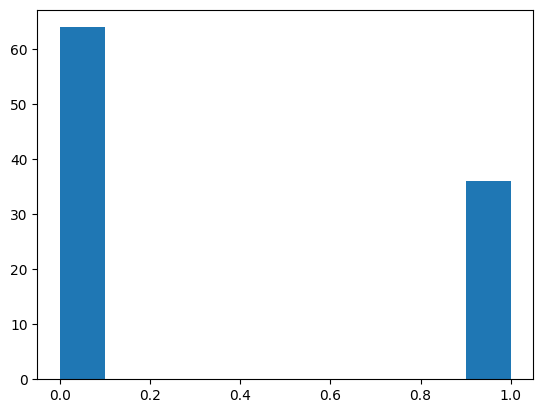

In [35]:
plt.hist(samples)

#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [37]:
# The histogram show that p is maybe around 0.35.
# let's try to calculate it. Averaging the outcomes will give me the
# most likelihood estimate.
mle = np.average(samples)
print(F"p is estimated at {mle}, which is our MLE.")

p is estimated at 0.36, which is our MLE.


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: The estimate is based on a sample of stochastic outcomes rather than deterministic outcomnes. By random chance, we could have ended up with a different distribution than the "most likely one" given the true probability parameter. 

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

In [38]:
# We'll simulate 100 outcomes (the size of our empirical sample)
# using our most likelihood estimate p_estimate.
# The average of the simulation gives us a new simulated probability.
# Doing it a 1000 times gives us the posterior distribution.
# Our simulation gives us values that fall well between 0 and 1 so we can just
# use a normal distribution for this.

ep_simulation_n = 1000

empirical_posterior = [
    np.average(bernoulli.rvs(mle, size=sample_size)) 
    for _ in range(0, ep_simulation_n)
]

(array([  7.,  27., 160., 206., 236., 238.,  87.,  31.,   6.,   2.]),
 array([0.21 , 0.244, 0.278, 0.312, 0.346, 0.38 , 0.414, 0.448, 0.482,
        0.516, 0.55 ]),
 <BarContainer object of 10 artists>)

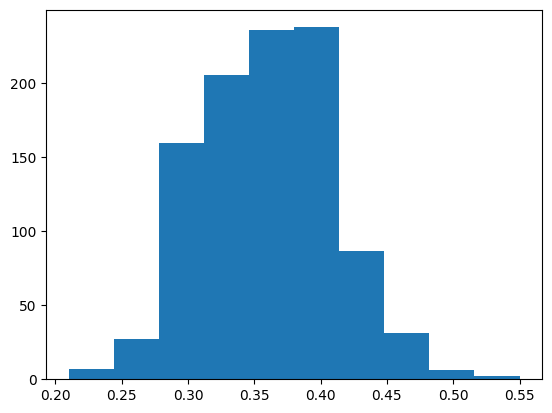

In [39]:
plt.hist(empirical_posterior)

#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

(array([625.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 375.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

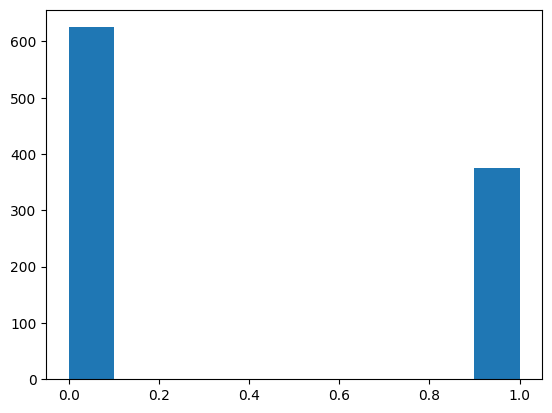

In [40]:
# Here we use the posterior predictive distribution of y 
# to generate new samples for a hypothetical unobserved student

# Generate new values of y corresponding to each value of pi_sims
post_pred_sims = []
for pi in empirical_posterior:
    y = bernoulli.rvs(pi)
    post_pred_sims.append(y)

plt.hist(post_pred_sims)

# There is a higher probability that the outcome of y = 0, which means that
# a given individual taken at random from this sample is more likely not to
# be a right-of-centre voter. Thus I would classify them as
# "not a right-of-centre voter".

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

#### a) Load the ANES 2020 sample, and check the number of respondents. (Hint: it's a `stata` file)

In [277]:
# Load ANES data
df = ...

# Check dataset size
print(df.shape)

(8280, 1381)


#### b) Subset the dataset to include only people who `intend to vote for president` in the pre-election study (Hint: in the codebook look for variable `V201032`)

In [278]:
# Focus on voters only 
# Turnout Intention variable: V201032
print(df['V201032'].value_counts())

...

V201032
1. Yes              7272
2. No                570
-1. Inapplicable     415
-9. Refused           13
-8. Don't know        10
Name: count, dtype: int64
(7272, 1381)


#### c) Define the outcome of interest as 1 if the voter will vote for the Republicans, 0 otherwise. (Hint: in the codebook look for variable `V201033` )

In [279]:
print(df['V201033'].value_counts())

V201033
1. Joe Biden                    3759
2. Donald Trump                 3016
5. Other candidate {SPECIFY}     175
3. Jo Jorgensen                  133
-9. Refused                      101
4. Howie Hawkins                  55
-8. Don't know                    33
-1. Inapplicable                   0
Name: count, dtype: int64


In [280]:
Y = ...

#### d) Create a design matrix including age, sex, education or anything else you think would be a good predictor of the vote. # Turn these features into a numeric matrix so we can use them to fit the model. 

#### Note: Remember the `dummy trap`...if you have a categorical variable with `m` possible values, you can only have `m-1` such variables be dummies in your model, due to perfect multi-collinearity...

In [281]:
# Age: 
age_num = pd.to_numeric(df['V201507x'], errors='coerce')

# College Degree or Higher:
college_edu = df['V201510']...

# Sex:
male_binary = df['V201600']...

# Ethnicity: 
white_binary = df['V201549x']...

# Create design matrix 
X = pd.DataFrame({
    'Age': age_num,
    'College_Degree_or_Higher': college_edu,
    'Sex_Male': male_binary,
    'Ethnicity_White': white_binary
})


# Display the first few rows of the DataFrame
print(X.head())

    Age  College_Degree_or_Higher  Sex_Male  Ethnicity_White
0  46.0                         1         1                0
1  37.0                         0         0                0
2  40.0                         0         0                1
3  41.0                         1         1                0
4  72.0                         0         1                0


#### e) Explore the correlation matrix between the covariates and the outcome. Which variables are most linearly related ? Does the direction of the correlation make sense ? Which covariates are most related to the outcome ? 

#### Hint: remember to drop missing values... for both X and Y...

In [282]:
YX = ...
YX = ...
# Examine the correlation between covariates and outcome (outcome is the first column)
# Can you identify some `perfect multicollinearity' that could hinder the estimation ? 
np.corrcoef(YX.T)

array([[ 1.        ,  0.0998711 , -0.06906375,  0.07301269,  0.22131516],
       [ 0.0998711 ,  1.        , -0.03289812,  0.0180753 ,  0.16486809],
       [-0.06906375, -0.03289812,  1.        , -0.02851965,  0.06376817],
       [ 0.07301269,  0.0180753 , -0.02851965,  1.        ,  0.02777518],
       [ 0.22131516,  0.16486809,  0.06376817,  0.02777518,  1.        ]])

#### f) Fit the logistic regression model using statsmodels. Make sure the estimation procedure has converged.
#### If not, examine the errors and figure out why it's not. Remember to drop the NAs.

In [298]:
Y = YX[:,0]
X = pd.DataFrame(YX[:,1:], columns=['Age', 'College_Degree', 'Sex_Male', 'Ethnicity_White'])  # Design matrix with column names
X_with_intercept = ...

model = ...

Optimization terminated successfully.
         Current function value: 0.642839
         Iterations 5


#### g) Get summary of regression output.

In [299]:
# Get summary results
...
print(summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6630
Model:                          Logit   Df Residuals:                     6625
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                 0.04954
Time:                        11:10:27   Log-Likelihood:                -4262.0
converged:                       True   LL-Null:                       -4484.2
Covariance Type:            nonrobust   LLR p-value:                 7.486e-95
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5528      0.102    -15.252      0.000      -1.752      -1.353
Age                 0.0081      0.002      4.987      0.000       0.005       0.011
College_Degree     -0.3418      

#### h) Simulate 1000 values for for each regression coefficient, from the empirical posterior distribution. Remember this is a Multivariate normal. Use  model.cov_params() to extract the covariance matrix. 

In [300]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = ...

#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

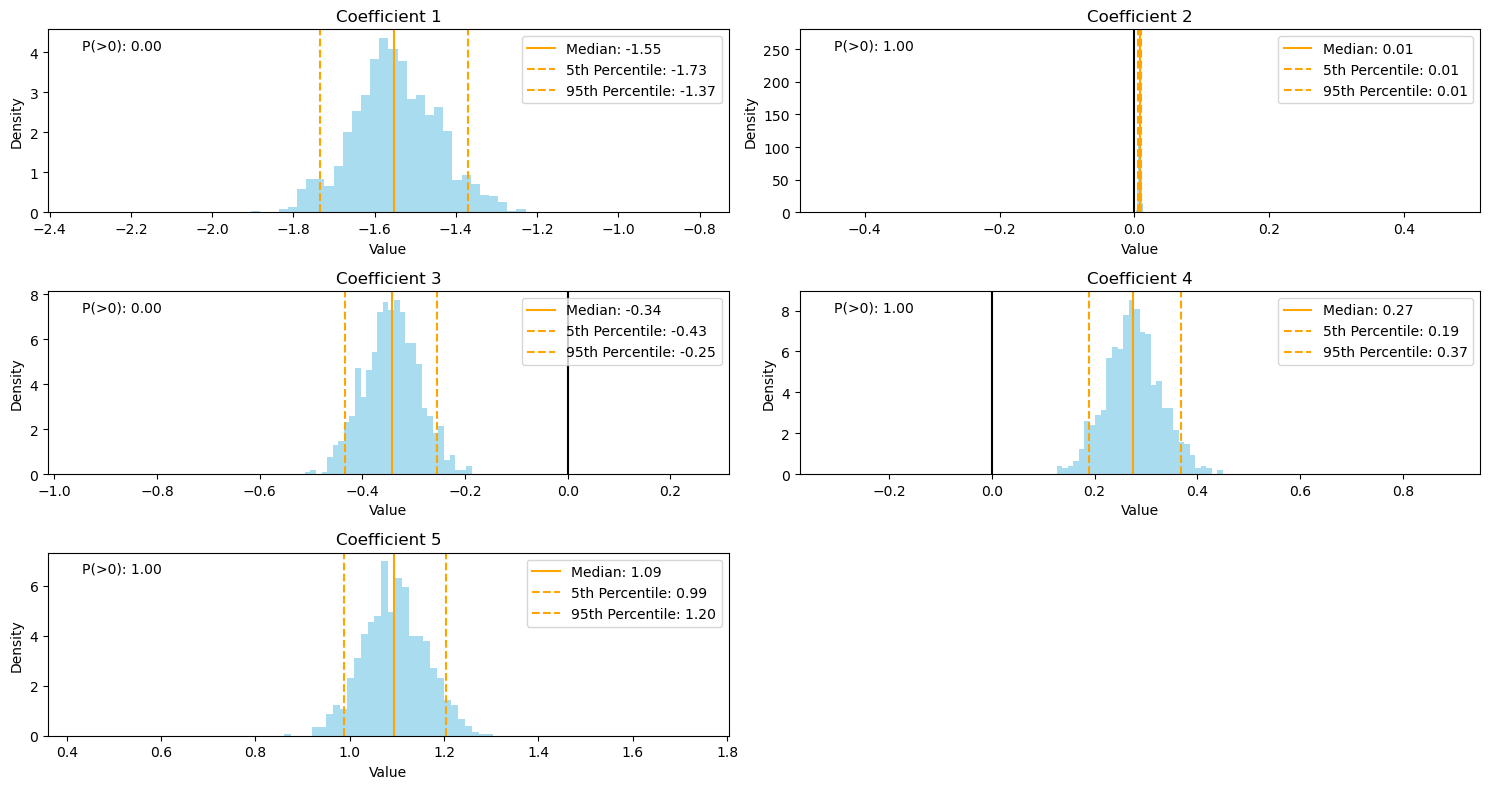

In [302]:
...

#### i) Now let's practice making predictions from this model that we learned. Below is definded the `average american voter`. For this hypothetical person, make a prediction for the probability of voting republican. Ensure to use simulations to gennerate samples of this probability,  and fully account for uncertainty. 

#### Hint: use the `logistic_sigmoid` function to turn simulations of $\mu$ into $\pi$.

In [304]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(...)

#### l) Now generate values from the posterior predictive distirbution of the outcome Y (So for this hypothetical average voter, simulate 1000 times who they will vote for). Who does the average american voter turn to in 2020

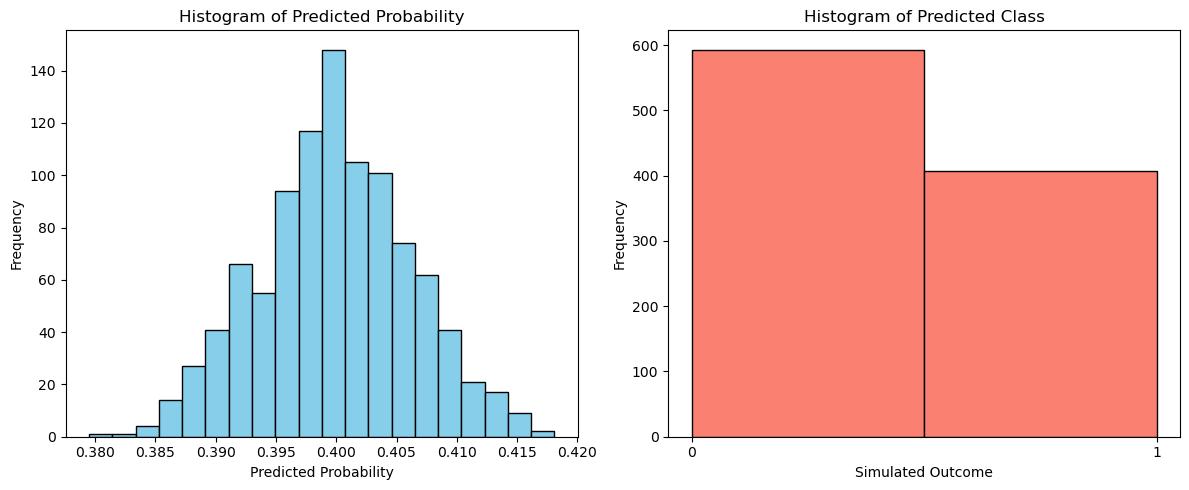

In [305]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = ...

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
